In [34]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import codes.data_utils
import importlib

importlib.reload(codes.data_utils)
from codes.data_utils import set_seed

set_seed(42)
# Load centrality data
centrality_df = pd.read_excel("data/Centrality_indices.xlsx")

In [35]:
clean_cities_df = pd.read_csv("data/clean_non_flagged_cities.csv")
clean_city_ids = set(clean_cities_df['Codmundv'].astype(int).unique())
len(clean_city_ids)

1335

In [36]:
pop_df = pd.read_csv("data/cleaned_population_2022.csv")
scaler = MinMaxScaler()
pop_df_filtered = pop_df[pop_df["ibgeID"].isin(clean_city_ids)].copy()
top_240_pop_cities = set(pop_df_filtered.sort_values(by="population", ascending=False)["ibgeID"].head(240).tolist())
print(top_240_pop_cities)
pop_df_filtered["Population_2025_Normalized"] = scaler.fit_transform(pop_df_filtered[["population"]])

{3302403, 2918407, 3541000, 2910727, 2103307, 2700300, 3301900, 4104204, 1501709, 1100304, 2930709, 4202008, 5221403, 5204508, 3523107, 3501608, 3552809, 3505708, 4126256, 3526704, 3300407, 2933307, 3522109, 4307005, 2928703, 4204608, 1302603, 3303500, 4208203, 3304524, 2910800, 3205200, 3538006, 1600600, 4109401, 3519071, 4322400, 3550308, 3302502, 3300456, 3503208, 3549805, 3169901, 4104303, 1501808, 2918001, 4108403, 2307700, 2600054, 1501303, 3302007, 3545209, 3536505, 1500800, 2919553, 3122306, 3147907, 3203205, 3548807, 4316808, 3557006, 3552403, 4209300, 3305109, 2931350, 3556503, 2101400, 3138203, 3522208, 3547809, 3513504, 1504422, 3547304, 4204202, 4101804, 3513009, 5108402, 2800308, 3525300, 3529401, 4323002, 3201209, 3205309, 1502400, 4203204, 5107909, 2304202, 3545803, 3503307, 3549904, 3304144, 3554003, 4305108, 5201108, 3502804, 5107925, 2103000, 4309209, 1501402, 1702109, 4304606, 1505502, 3510500, 3548906, 4316907, 3518701, 3557105, 2507507, 3552502, 3526902, 2925303, 

In [37]:
import codes.extract_backbone

importlib.reload(codes.extract_backbone)
from codes.extract_backbone import extract_backbone_from_files_brazil

backbone_df, backbone_cities = extract_backbone_from_files_brazil(
    centrality_path="data/Centrality_indices.xlsx",
    mobility_edges_path="data/Road_and_waterway_connections_database_2016.xlsx",
    alpha=0.01,
    city_whitelist=top_240_pop_cities
)

print(f"Backbone extracted with {len(backbone_df)} edges")
print(backbone_df[['source', 'target', 'weekly_flow', 'pij']].head())


[✓] Backbone extracted and saved to 'data/mobility_backbone_brazil.csv'.
Backbone extracted with 836 edges
      source   target  weekly_flow       pij
9    1301902  1501402          3.5  0.819107
12   1301902  1501808          1.5  0.925808
26   1301902  1506807         13.5  0.108616
85   3520509  3552403          0.0  1.000000
125  1302603  1501808          1.5  0.880150


In [38]:
pop_df_filtered = pop_df_filtered[pop_df_filtered["ibgeID"].isin(backbone_cities)]

In [39]:
from codes.graph_utils import build_pyg_graph_from_backbone

pop_dict = dict(zip(pop_df_filtered["ibgeID"], pop_df_filtered["Population_2025_Normalized"]))
node_pop_features = [pop_dict.get(city, 0.0) for city in backbone_cities]

centrality_df = centrality_df[centrality_df['Codmundv'].isin(backbone_cities)].copy()
pyg_data = build_pyg_graph_from_backbone(centrality_df, backbone_df)
pyg_data.x = torch.tensor(node_pop_features).unsqueeze(1)
print(pyg_data)

[✓] Graph built with 215 nodes and 836 edges.
[✓] Converted to PyTorch Geometric format.
Data(edge_index=[2, 1672], name=[215], weight=[1672], edge_attr=[1672, 1], num_nodes=215, x=[215, 1])


In [40]:
import numpy as np
from codes.load_and_save_covid_data import load_and_save_covid_data

covid_df = load_and_save_covid_data()
covid_df = covid_df[covid_df["ibgeID"].isin(backbone_cities)]

print(f"Full date range: {covid_df['date'].min()} to {covid_df['date'].max()}")
print(f"Total records: {len(covid_df):,}")

negative_counts = (covid_df.select_dtypes(include=[np.number]) < 0).sum()
print("📉 Negative values per column:")
print(negative_counts[negative_counts > 0])


[✓] Found saved COVID dataset at data/covid_brazil_combined.csv. Loading it...
Full date range: 2020-02-25 00:00:00 to 2023-03-18 00:00:00
Total records: 233,301
📉 Negative values per column:
newDeaths    1841
newCases     3557
dtype: int64


In [41]:
import codes.preprocess_covid_brazil
importlib.reload(codes.preprocess_covid_brazil)
from codes.preprocess_covid_brazil import filter_and_scale_covid_by_centrality

filtered_scaled_covid_df = filter_and_scale_covid_by_centrality(covid_df, city_whitelist=backbone_cities)

[✓] Filtered to 215 cities, 233,301 rows.
[✓] Negative values in 'newCases' and 'newDeaths' clipped to 0.
[✓] Computed cases and deaths per 100,000 population.
[✓] Applied Z-score normalization.
[✓] Saved filtered + scaled COVID data to 'data/filtered_scaled_covid.csv'.


In [42]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("cpu")
    print('Using cpu')
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Using cpu


In [43]:
from codes.data_utils import prepare_temporal_graph_data_non_overlapping, generate_sliding_temporal_graph_data, \
    prepare_temporal_graph_data_non_overlapping

# Traditional (non-sliding) approach
X_train_static, X_test_static, Y_train_static, Y_test_static = prepare_temporal_graph_data_non_overlapping(
    filtered_scaled_covid_df,
    sequence_length=15,
    feature_column="z_newCases",
    device=device
)

# Sliding window approach
X_train_slide, X_test_slide, Y_train_slide, Y_test_slide = generate_sliding_temporal_graph_data(
    filtered_scaled_covid_df,
    input_window=14,
    output_window=1,
    feature_column="z_newCases",
    device=device
)

Y_train_slide = Y_train_slide.squeeze(1)
print(Y_train_slide.shape)

Y_test_slide = Y_test_slide.squeeze(1)
print(Y_test_slide.shape)

# Compare number of samples
total_static = len(X_train_static) + len(X_test_static)
total_slide = len(X_train_slide) + len(X_test_slide)

print("📊 Sample Count Comparison")
print(f"Static window (15 input, 1 output): {total_static} samples")
print(f"Sliding window (10 input, 1 output): {total_slide} samples")
print(f"⬆️ Gain: {total_slide - total_static} samples (+{100 * (total_slide - total_static) / total_static:.2f}%)")


[📉] (Non-overlapping) X shape: torch.Size([69, 15, 215, 1]) | Y shape: torch.Size([69, 215, 1])
[📉] Train: torch.Size([55, 15, 215, 1]) | Test: torch.Size([14, 15, 215, 1])
[✓] Sliding window: X torch.Size([1104, 14, 215, 1]), Y torch.Size([1104, 1, 215, 1])
[✓] Train: torch.Size([883, 14, 215, 1]), Test: torch.Size([221, 14, 215, 1])
torch.Size([883, 215, 1])
torch.Size([221, 215, 1])
📊 Sample Count Comparison
Static window (15 input, 1 output): 69 samples
Sliding window (10 input, 1 output): 1104 samples
⬆️ Gain: 1035 samples (+1500.00%)


In [44]:
import codes.models.global_spatiotemporal_model
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

importlib.reload(codes.models.global_spatiotemporal_model)

from codes.models.global_spatiotemporal_model import SpatiotemporalTransformer

N = len(backbone_cities)

# You are not currently using static node features (like population), so graph_feat_dim = 0
model = SpatiotemporalTransformer(
    input_dim=1,         # One feature per city per day: "newCases"
    gcn_dim=1,           # No static node features (population, centrality) passed
    hidden_dim=64,       # Transformer + GCN hidden size
    nhead=2,             # Number of transformer heads
    num_layers=1,        # Transformer layers
    num_nodes=N,         # Number of nodes in the graph
    forecast_dim=1       # Predict one value per node (1-day ahead cases)
).to(device)

# Loss function
criterion = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.95) 

In [28]:
model = SpatiotemporalTransformer(
    input_dim=1,         # One feature per city per day: "newCases"
    gcn_dim=1,           # No static node features (population, centrality) passed
    hidden_dim=64,       # Transformer + GCN hidden size
    nhead=2,             # Number of transformer heads
    num_layers=1,        # Transformer layers
    num_nodes=N,         # Number of nodes in the graph
    forecast_dim=1       # Predict one value per node (1-day ahead cases)
).to(device) 

state_dict = torch.load("models/Brazil-Experiment-Cleaned-Global-Attempt-4-Final.pth")
model.load_state_dict(state_dict, strict=False)

RuntimeError: Error(s) in loading state_dict for SpatiotemporalTransformer:
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([32]).

In [45]:
from torch.utils.data import Dataset, DataLoader

class CovidGraphDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [46]:
batch_size = 32  # You can tune this based on your GPU

train_dataset = CovidGraphDataset(X_train_slide, Y_train_slide)
test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [47]:
edge_index = pyg_data.edge_index.to(device)
edge_weight = pyg_data.edge_attr.view(-1).to(device)

In [48]:
import time
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn

# --- trackers ---
train_loss_hist, val_loss_hist, val_loss_ema, lr_hist, epoch_times = [], [], [], [], []

# Use your existing train criterion; plain MSE for clean eval averaging
criterion_train = criterion
criterion_eval  = nn.MSELoss(reduction='mean')

# Cache node features on device once (if your model expects them)
node_feats = pyg_data.x.to(device) if hasattr(pyg_data, "x") and pyg_data.x is not None else None

@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    total, count = 0.0, 0
    for vx, vy in data_loader:
        vx = vx.to(device)              # [B, T, N, F]
        vy = vy.to(device).squeeze(1)   # [B, N, 1]
        out = model(vx, edge_index, edge_weight, node_features=node_feats)  # [B, N, 1]
        loss = criterion_eval(out, vy)
        total += loss.item()
        count += 1
    model.train()
    return total / max(count, 1)

def ema_append(raw_series, ema_series, alpha=0.2):
    """Append EMA of the last raw point into ema_series with smoothing alpha."""
    x = raw_series[-1]
    if not ema_series:
        ema_series.append(x)
    else:
        ema_series.append(alpha * x + (1 - alpha) * ema_series[-1])

# -----------------------
# Training Loop (120 ep)
# -----------------------
num_epochs = 20
model.train()

for epoch in range(num_epochs):
    start_time = time.time()
    total_loss, num_batches = 0.0, 0

    pbar = tqdm(train_loader, desc=f"🧠 Epoch {epoch+1}/{num_epochs}", position=0, leave=True)
    for batch_X, batch_Y in pbar:
        batch_X = batch_X.to(device)              # [B, T, N, F]
        batch_Y = batch_Y.to(device).squeeze(1)   # [B, N, 1]

        optimizer.zero_grad(set_to_none=True)
        output = model(batch_X, edge_index, edge_weight, node_features=node_feats)  # [B, N, 1]
        loss = criterion_train(output, batch_Y)

        loss.backward()
        # Optional: gradient clipping for stability
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        current_lr = optimizer.param_groups[0]['lr']
        lr_hist.append(current_lr)

        pbar.set_postfix({"Loss": f"{loss.item():.4f}", "LR": f"{current_lr:.6f}"})

    # ---- End of epoch metrics ----
    avg_train = total_loss / max(num_batches, 1)
    train_loss_hist.append(avg_train)

    # Validation
    val_loss = evaluate(model, test_loader)
    val_loss_hist.append(val_loss)
    ema_append(val_loss_hist, val_loss_ema, alpha=0.2)

    # Timing
    elapsed = time.time() - start_time
    epoch_times.append(elapsed)

    print(
        f"✅ Epoch {epoch+1}/{num_epochs} — "
        f"Train: {avg_train:.4f} | Val: {val_loss:.4f} | EMA(0.2): {val_loss_ema[-1]:.4f} "
        f"| LR: {optimizer.param_groups[0]['lr']:.6f} | Time: {elapsed:.2f}s"
    )

    # ---- Scheduler step (choose ONE style) ----
    scheduler.step()            # e.g., StepLR, CosineAnnealingLR, OneCycleLR (if applicable)
    # scheduler.step(val_loss)  # if using ReduceLROnPlateau

print(
    f"\nAverage epoch time: {np.mean(epoch_times):.2f}s "
    f"(min: {np.min(epoch_times):.2f}s, max: {np.max(epoch_times):.2f}s)"
)

# -----------------------
# After training, you can plot with matplotlib:
# -----------------------
# import matplotlib.pyplot as plt
# plt.figure(); plt.plot(train_loss_hist); plt.title("Train Loss")
# plt.figure(); plt.plot(val_loss_hist); plt.title("Val Loss")
# plt.figure(); plt.plot(val_loss_ema);  plt.title("Val Loss EMA (α=0.2)")
# plt.figure(); plt.plot(lr_hist);       plt.title("Learning Rate")
# plt.show()


🧠 Epoch 1/20: 100%|██████████| 28/28 [03:43<00:00,  7.98s/it, Loss=1.8799, LR=0.001000]


✅ Epoch 1/20 — Train: 0.9561 | Val: 0.4077 | EMA(0.2): 0.4077 | LR: 0.001000 | Time: 231.05s


🧠 Epoch 2/20:   0%|          | 0/28 [00:07<?, ?it/s]


KeyboardInterrupt: 

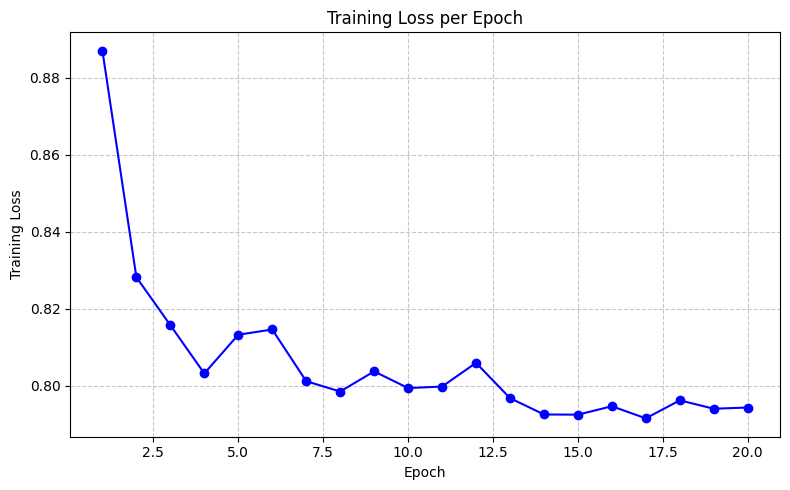

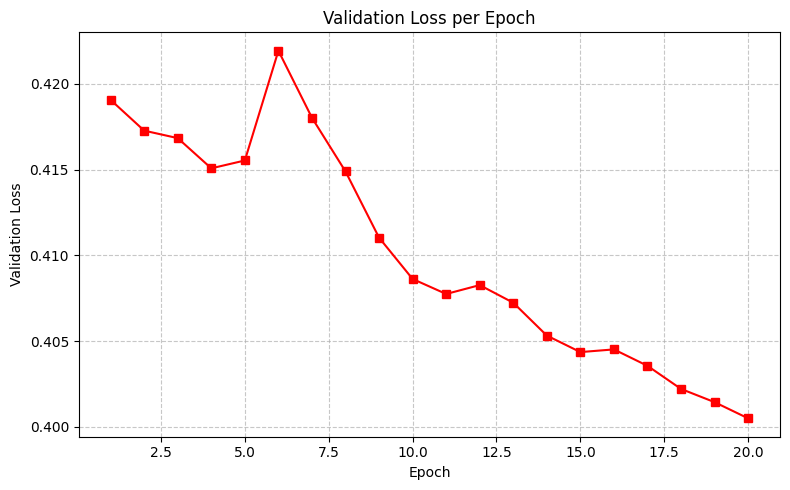

In [16]:
import matplotlib.pyplot as plt

# Plot Training Loss
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_loss_hist)+1), train_loss_hist, marker="o", color="blue")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("./figures/spain_local_transformer_train_loss.png", dpi=300)
plt.show()

# Plot Validation Loss
plt.figure(figsize=(8,5))
plt.plot(range(1, len(val_loss_ema)+1), val_loss_ema, marker="s", color="red")
plt.title("Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("./figures/spain_local_transformer_val_loss.png", dpi=300)
plt.show()

In [25]:
from tqdm import tqdm

test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="🔍 Testing", leave=False)

    for batch_X, batch_Y in progress_bar:
        batch_X = batch_X.to(device)  # [B, T, N, 1]
        batch_Y = batch_Y.to(device)  # [B, N, 1]

        output = model(batch_X, edge_index, edge_weight, node_features=pyg_data.x.to(device))  # [B, N, 1]

        loss = criterion(output, batch_Y)
        test_loss += loss.item()

        # Store for plotting later
        predictions.append(output.cpu())     # [B, N, 1]
        actuals.append(batch_Y.cpu())        # [B, N, 1]

        progress_bar.set_postfix({"Loss": loss.item()})

# Stack everything: [B, N, 1] -> [Total_samples, N, 1]
predictions = torch.cat(predictions, dim=0)
actuals = torch.cat(actuals, dim=0)

print(f"\n✅ Final Test Loss: {test_loss / len(test_loader):.4f}")



✅ Final Test Loss: 0.3993


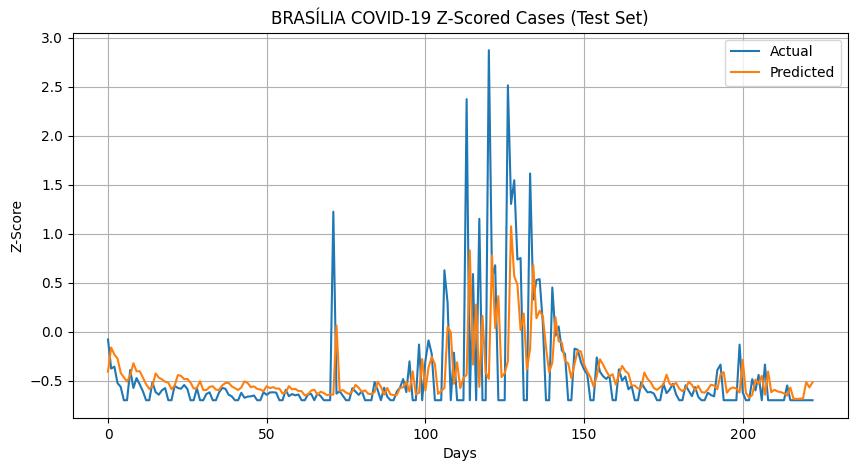

📉 RMSE for BRASÍLIA: 0.4918


In [26]:
import matplotlib.pyplot as plt
import networkx as nx

G2 = nx.Graph()
for _, row in centrality_df.iterrows():
    city_id = int(row['Codmundv'])
    G2.add_node(city_id, name=row['nomemun'])

# Collapse last dimension
pred_array = predictions.squeeze(-1).numpy()  # [T, N]
actual_array = actuals.squeeze(-1).numpy()    # [T, N]

# BRASÍLIA IBGE code
sp_code = 5300108
city_id_list = list(G2.nodes())
sp_index = city_id_list.index(sp_code)

sp_preds = pred_array[:, sp_index]
sp_actuals = actual_array[:, sp_index]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(sp_actuals, label='Actual')
plt.plot(sp_preds, label='Predicted')
plt.title("BRASÍLIA COVID-19 Z-Scored Cases (Test Set)")
plt.xlabel("Days")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.show()


from sklearn.metrics import mean_squared_error
import numpy as np

rmse_sp = np.sqrt(mean_squared_error(sp_actuals, sp_preds))
print(f"📉 RMSE for BRASÍLIA: {rmse_sp:.4f}")



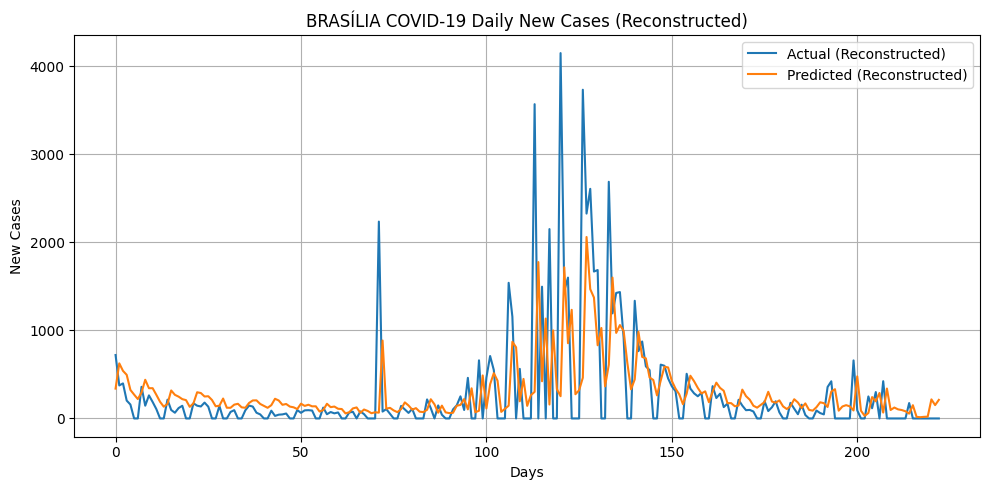

📉 RMSE for BRASÍLIA (Reconstructed): 571.37
📉 SMAPE for SP: 59.37%
📈 MDA for SP: 34.68%


In [27]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import mean_squared_error
import numpy as np

# Build city graph
G2 = nx.Graph()
for _, row in centrality_df.iterrows():
    city_id = int(row['Codmundv'])
    G2.add_node(city_id, name=row['nomemun'])

# Collapse last dimension
pred_array = predictions.squeeze(-1).numpy()  # [T, N]
actual_array = actuals.squeeze(-1).numpy()    # [T, N]

# BRASÍLIA IBGE code
sp_code = 5300108
city_id_list = list(G2.nodes())
sp_index = city_id_list.index(sp_code)


sp_preds_z = pred_array[:, sp_index]
sp_actuals_z = actual_array[:, sp_index]

# 🧠 Get mean and std from original covid_df
sp_original = covid_df[covid_df['ibgeID'] == sp_code].copy()
sp_original['newCases'] = sp_original['newCases'].clip(lower=0)
sp_original = sp_original.sort_values('date')
mean_sp = sp_original['newCases'].mean()
std_sp = sp_original['newCases'].std(ddof=0)

# 🔁 Reconstruct original values
sp_preds = sp_preds_z * std_sp + mean_sp
sp_actuals = sp_actuals_z * std_sp + mean_sp

# 📈 Plot reconstructed
plt.figure(figsize=(10, 5))
plt.plot(sp_actuals, label='Actual (Reconstructed)')
plt.plot(sp_preds, label='Predicted (Reconstructed)')
plt.title("BRASÍLIA COVID-19 Daily New Cases (Reconstructed)")
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("./figures/global_transformer_brasilia_top_40.png", dpi=300)
plt.show()

# 📉 RMSE in original scale
rmse_sp = np.sqrt(mean_squared_error(sp_actuals, sp_preds))
print(f"📉 RMSE for BRASÍLIA (Reconstructed): {rmse_sp:.2f}")

# SMAPE = Symmetric Mean Absolute Percentage Error
def smape(y_true, y_pred):
    return 100 * np.mean(
         np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)
    )


def mean_directional_accuracy(actual, predicted):
    # Ensure arrays are 1D
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()

    # Compute directional changes
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)

    # Compare signs of differences
    correct_directions = (actual_diff * pred_diff) > 0

    # Compute MDA
    return 100 * np.mean(correct_directions)


smape_sp = smape(sp_actuals, sp_preds)
print(f"📉 SMAPE for SP: {smape_sp:.2f}%")

mda_sp = mean_directional_accuracy(sp_actuals, sp_preds)
print(f"📈 MDA for SP: {mda_sp:.2f}%")


In [334]:
# Filter BRASÍLIA full series
sp_full = filtered_scaled_covid_df[filtered_scaled_covid_df['ibgeID'] == sp_code].sort_values('date')

# Extract full z-scored series
full_z_series = sp_full['z_newCases'].tolist()
full_dates = sp_full['date'].tolist()


In [335]:
from sklearn.metrics import mean_squared_error
import numpy as np

# pred_array and actual_array are shaped [T, N] — where T is time and N is number of cities
num_cities = pred_array.shape[1]

# Calculate RMSE for each city
rmses = []
for i in range(num_cities):
    rmse = np.sqrt(mean_squared_error(actual_array[:, i], pred_array[:, i]))
    rmses.append(rmse)

# Compute average RMSE
avg_rmse = np.mean(rmses)
print(f"📊 Average RMSE across all cities: {avg_rmse:.4f}")

# Calculate SMAPE for each city
smapes = []
for i in range(num_cities):
    smape_i = smape(actual_array[:, i], pred_array[:, i])
    smapes.append(smape_i)

# Compute average SMAPE
avg_smape = np.mean(smapes)
print(f"📊 Average SMAPE across all cities: {avg_smape:.2f}%")

mdas = []
for i in range(num_cities):
    mda_i = mean_directional_accuracy(actual_array[:, i], pred_array[:, i])
    mdas.append(mda_i)

# Compute average MDA
avg_mda = np.mean(mdas)
print(f"📈 Average MDA across all cities: {avg_mda:.2f}%")


📊 Average RMSE across all cities: 0.5355
📊 Average SMAPE across all cities: 26.91%
📈 Average MDA across all cities: 32.08%


In [336]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Map: city code → population
pop_dict = dict(zip(pop_df_filtered["ibgeID"], pop_df_filtered["population"]))

rmse_per_100k_list = []

print(len(backbone_cities))

for i, city_code in enumerate(backbone_cities):
    if city_code not in pop_dict:
        continue  # skip if population not found

    # Get predictions and labels (standardized)
    pred_z = pred_array[:, i]
    actual_z = actual_array[:, i]

    # Restore real case counts from z-score
    city_df = covid_df[covid_df['ibgeID'] == city_code].copy()
    city_df['newCases'] = city_df['newCases'].clip(lower=0).sort_values()

    mean_city = city_df['newCases'].mean()
    std_city = city_df['newCases'].std(ddof=0)

    pred_real = pred_z * std_city + mean_city
    actual_real = actual_z * std_city + mean_city

    # Convert to cases per 100k
    population = pop_dict[city_code]
    
    pred_per_100k = pred_real / population * 100000
    actual_per_100k = actual_real / population * 100000

    # Compute RMSE per 100k
    rmse = np.sqrt(mean_squared_error(actual_per_100k, pred_per_100k))
        
    rmse_per_100k_list.append(rmse)

# Average across all cities
avg_rmse_per_100k = np.mean(rmse_per_100k_list)
print(f"📉 Average RMSE per 100k population: {avg_rmse_per_100k:.2f}")


37
📉 Average RMSE per 100k population: 14.77


In [328]:
city_rmse_pairs = list(zip(city_id_list, rmses))
sorted_city_rmses = sorted(city_rmse_pairs, key=lambda x: x[1])

print("\n🔝 Top 5 cities with highest RMSE:")
for city_id, rmse in sorted_city_rmses[-5:][::-1]:
    print(f"City ID: {city_id} — RMSE: {rmse:.4f}")

print("\n✅ Top 5 cities with lowest RMSE:")
for city_id, rmse in sorted_city_rmses[:5]:
    print(f"City ID: {city_id} — RMSE: {rmse:.4f}")



🔝 Top 5 cities with highest RMSE:
City ID: 4205407 — RMSE: 1.7733
City ID: 3518800 — RMSE: 1.2262
City ID: 5201108 — RMSE: 1.0783
City ID: 3509502 — RMSE: 1.0046
City ID: 3538709 — RMSE: 0.8930

✅ Top 5 cities with lowest RMSE:
City ID: 3529401 — RMSE: 0.0921
City ID: 3525904 — RMSE: 0.1280
City ID: 1501402 — RMSE: 0.1565
City ID: 1302603 — RMSE: 0.1632
City ID: 3543402 — RMSE: 0.1946


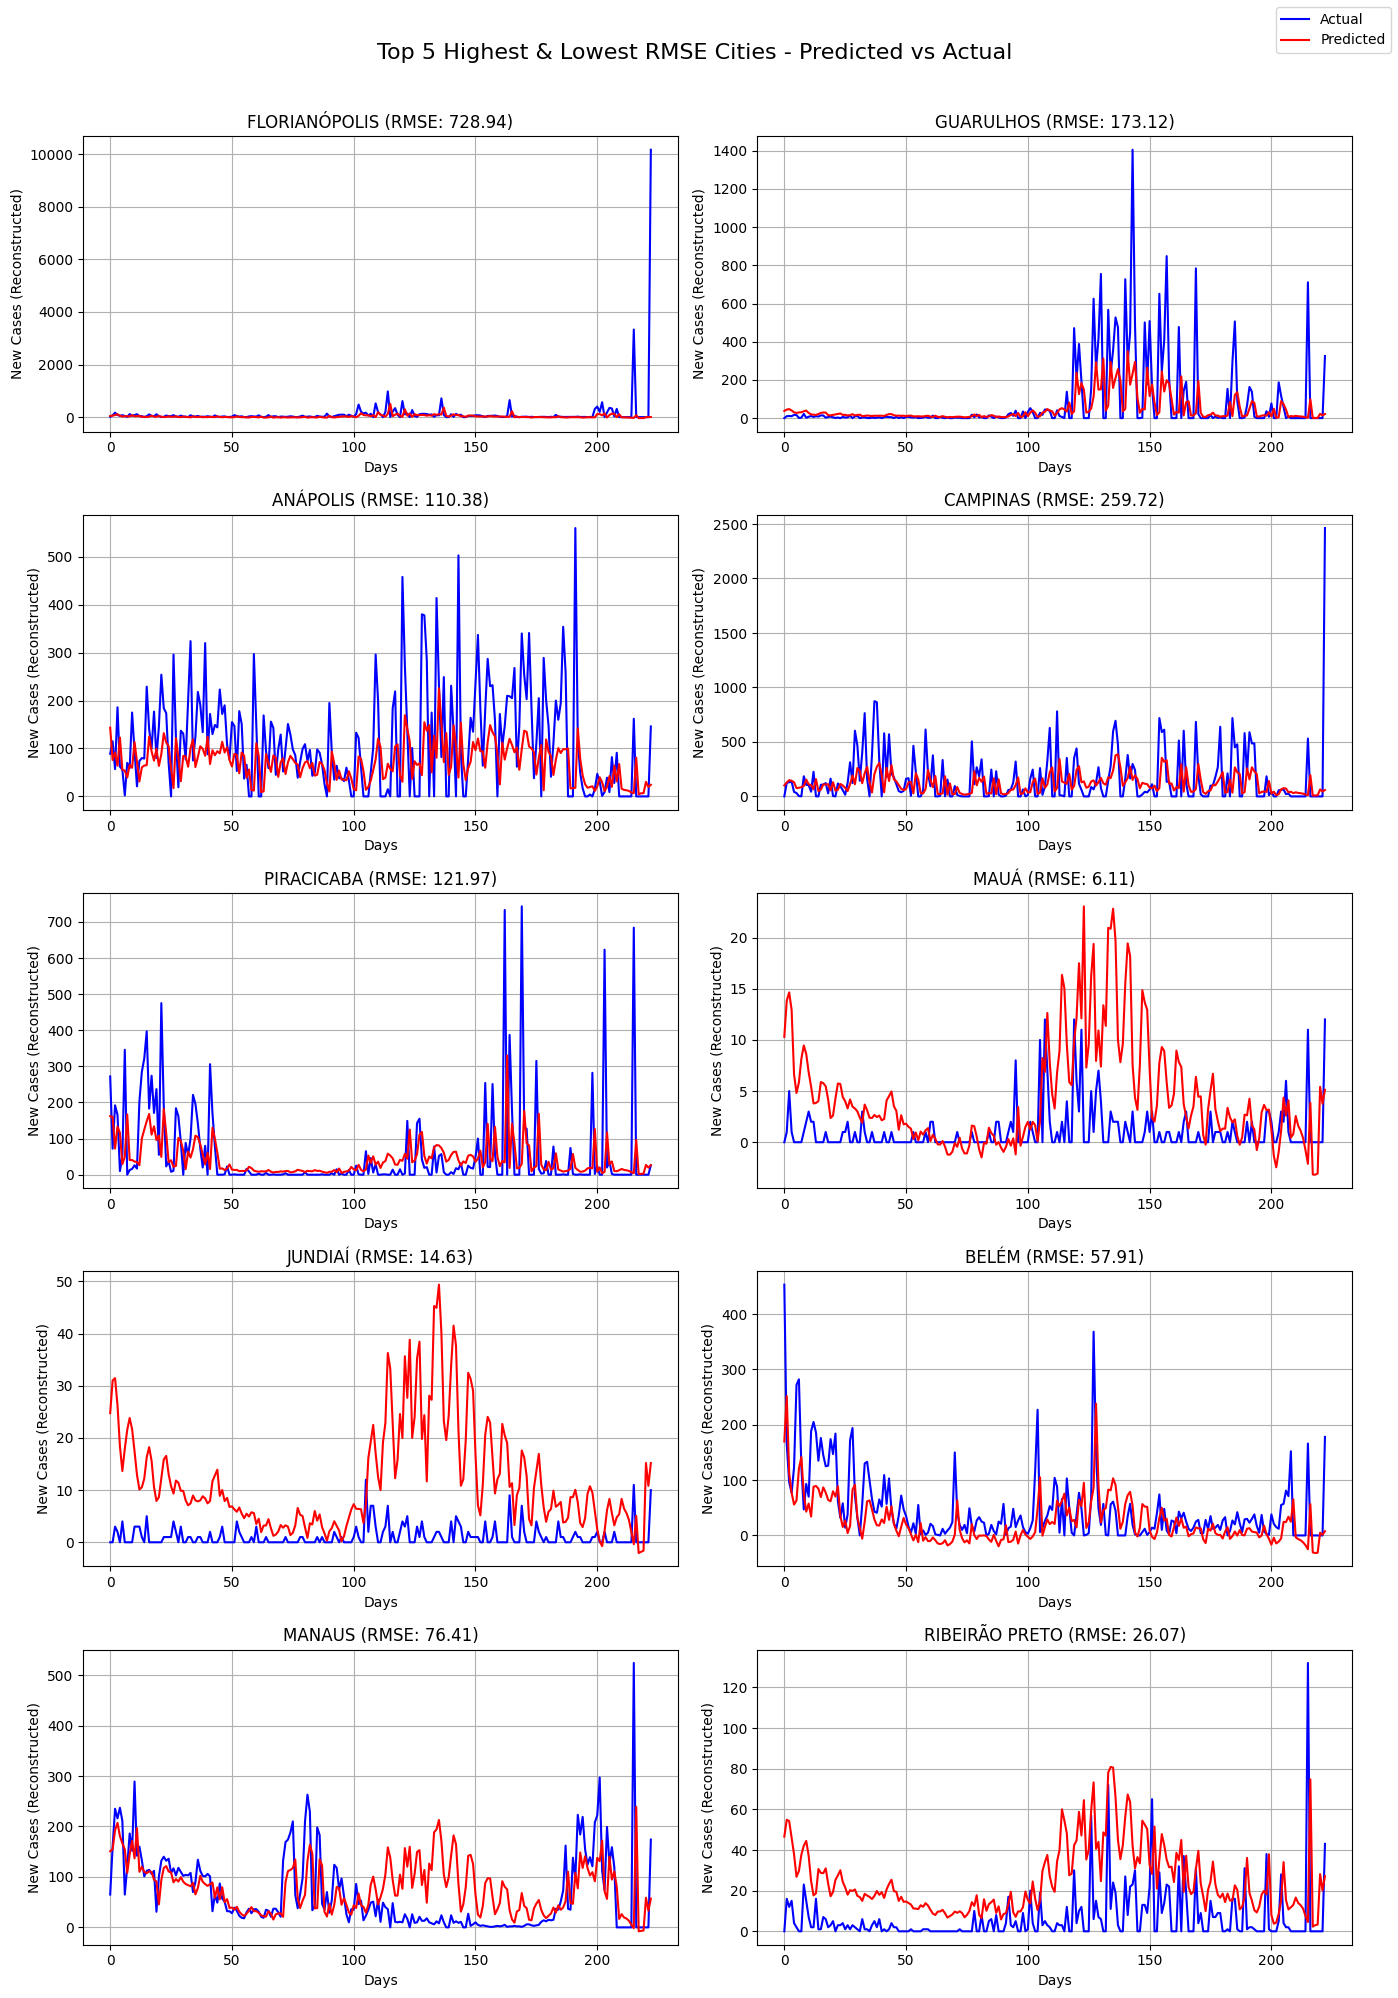

In [329]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Compute RMSE per city
city_rmses = []
for i, city_id in enumerate(city_id_list):
    actual = actual_array[:, i]
    pred = pred_array[:, i]
    rmse = np.sqrt(mean_squared_error(actual, pred))
    city_rmses.append((city_id, rmse))

# Step 2: Sort and get top 5 and bottom 5
top_5 = sorted(city_rmses, key=lambda x: x[1], reverse=True)[:5]
bottom_5 = sorted(city_rmses, key=lambda x: x[1])[:5]

# Step 3: Create mapping from city ID to name
id_to_name = dict(zip(centrality_df['Codmundv'], centrality_df['nomemun']))

# Step 4: Plotting helper
def plot_city_prediction(city_id, ax):
    city_name = id_to_name.get(city_id, f"ID {city_id}")
    city_index = city_id_list.index(city_id)

    # Get Z-scored predictions and actuals
    pred_z = pred_array[:, city_index]
    actual_z = actual_array[:, city_index]

    # Compute mean & std from original covid_df
    city_data = covid_df[covid_df['ibgeID'] == city_id].copy()
    city_data['newCases'] = city_data['newCases'].clip(lower=0)
    mean = city_data['newCases'].mean()
    std = city_data['newCases'].std(ddof=0)

    # Invert Z-score to get original scale
    pred = pred_z * std + mean
    actual = actual_z * std + mean

    # Plot
    ax.plot(actual, label='Actual', color='blue')
    ax.plot(pred, label='Predicted', color='red')
    rmse = np.sqrt(mean_squared_error(actual, pred))
    ax.set_title(f"{city_name} (RMSE: {rmse:.2f})")
    ax.set_xlabel("Days")
    ax.set_ylabel("New Cases (Reconstructed)")
    ax.grid(True)


# Step 5: Plot all 10 cities
fig, axs = plt.subplots(5, 2, figsize=(14, 20))
fig.suptitle("Top 5 Highest & Lowest RMSE Cities - Predicted vs Actual", fontsize=16)

for i, (city_id, _) in enumerate(top_5 + bottom_5):
    ax = axs[i // 2, i % 2]
    plot_city_prediction(city_id, ax)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0, 0.98, 0.97])
plt.show()


In [337]:
import os
import torch

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/Brazil-Experiment-Cleaned-Global-Attempt-4-Final.pth")